# SARIMAX modelling and forecasting

This notebook is a personal journal on how I dealt with modelling and forecasting of airbnb listing reviews in Copenhagen.

<b> Dataset </b>:
I found the dataset here: http://insideairbnb.com/get-the-data.html

One can find their favorite cities and potentially analyse the demand for airbnb. Once downloaded, one can save it as 'reviews.csv' in the same directory as the notebook otherwise, one can call its address.

### Step 1: Importing packages and diagnosing the dataset

In [1693]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

df = pd.read_csv('reviews.csv')

In [1136]:
df.head()

,listing_id,date
0,6983,2009-09-04
1,6983,2009-09-07
2,6983,2009-09-28
3,6983,2009-12-17
4,6983,2010-01-04


In [1137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386954 entries, 0 to 386953
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  386954 non-null  int64 
 1   date        386954 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.9+ MB


#### Checkpoint
<b> Observation </b>: The given data is a list of <i>listing_id (column 1)</i> and <i>review date (column 2)</i>, corresponding to unique Airbnb apartments and its reviews in Copenhagen.

<b> What's next?</b>: We want to forecast the total Airbnb reviews in Copenhagen. This way, we could get some insights, not only about rental activity, but also about Copenhagen as a competitive tourist destination. 

### Step 2: Prepare the dataset for ARIMA time series analysis

In [2355]:
#counting the number of reviews per day
df = df.groupby('date').count()

#making the date as the dataframe's index
df.index = pd.to_datetime(df.index) 

#uniforming the time frequency domain, we impute 0 in days where no reviews were given  
df = df.asfreq(freq='D',fill_value=0)

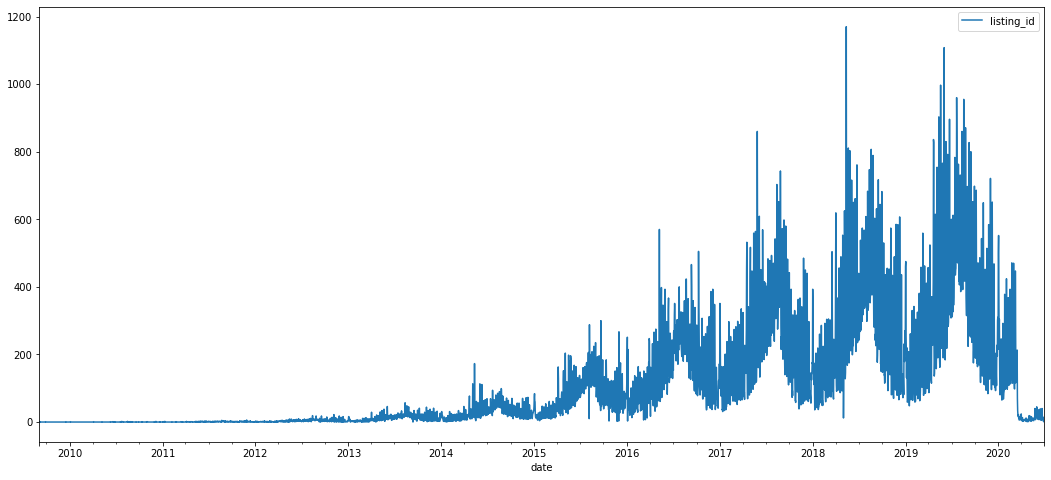

In [1696]:
df.plot(figsize=(18,8));

<b> Observation</b>:The figure above shows the increasing number of reviews as we move into the future. We can also observe the cyclic pattern, which describes the yearly seasonality of number of reviews.

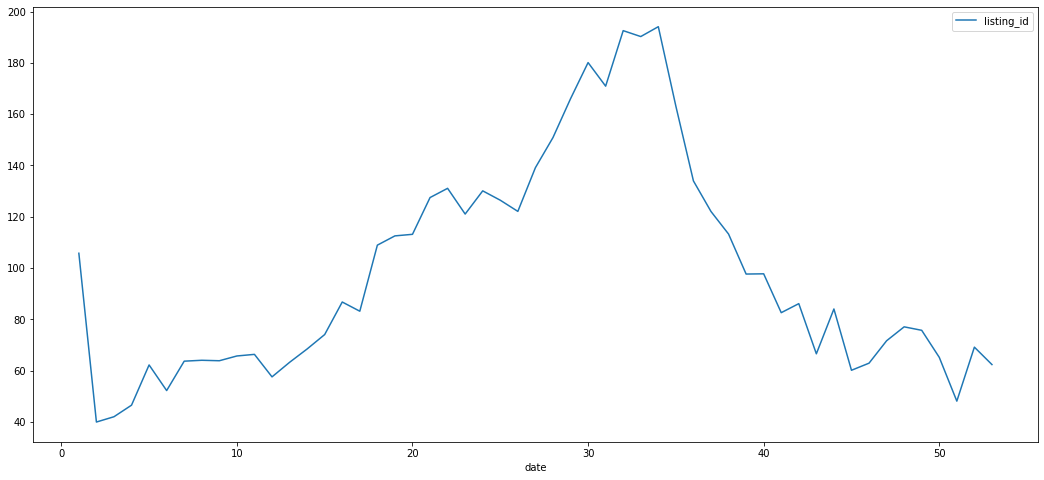

In [1697]:
df.groupby(df.index.week).mean().plot(figsize=(18,8));

<b> Observation </b>: Digging deeper into the yearly seasonality, we can see that weeks 1, 25, and 33 incurred the most number of reviews as shown in the figure above. This coincides to holidays such as new-year, spring, and summer. This also suggests that Airbnbs are in use (demanded) during these times.

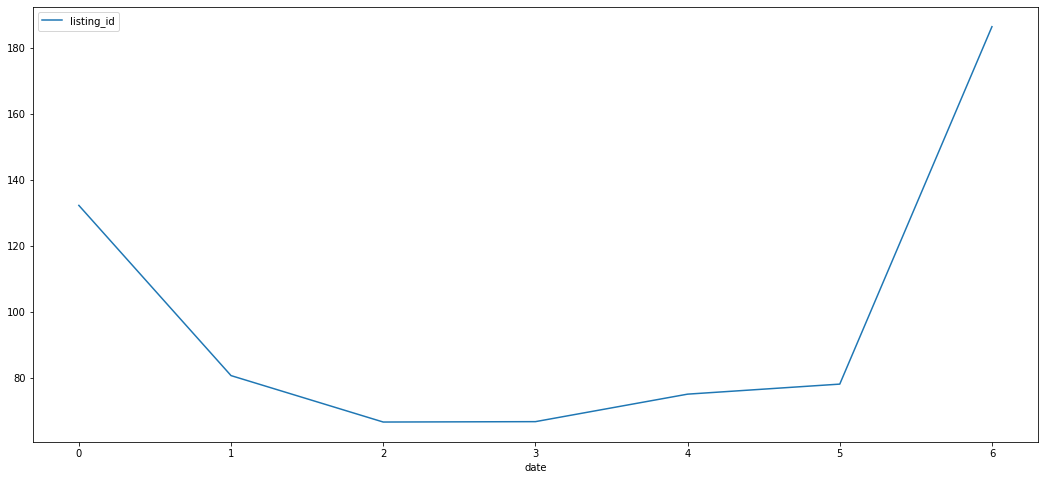

In [1698]:
df.groupby(df.index.dayofweek).mean().plot(figsize=(18,8));

<b> Observation </b>: Weekends show the highest number of reviews in comparison to weekdays as shown from the figure above. This could be due to the fact that people are relatively more available in weekends to deal with this type of auxillary activity.

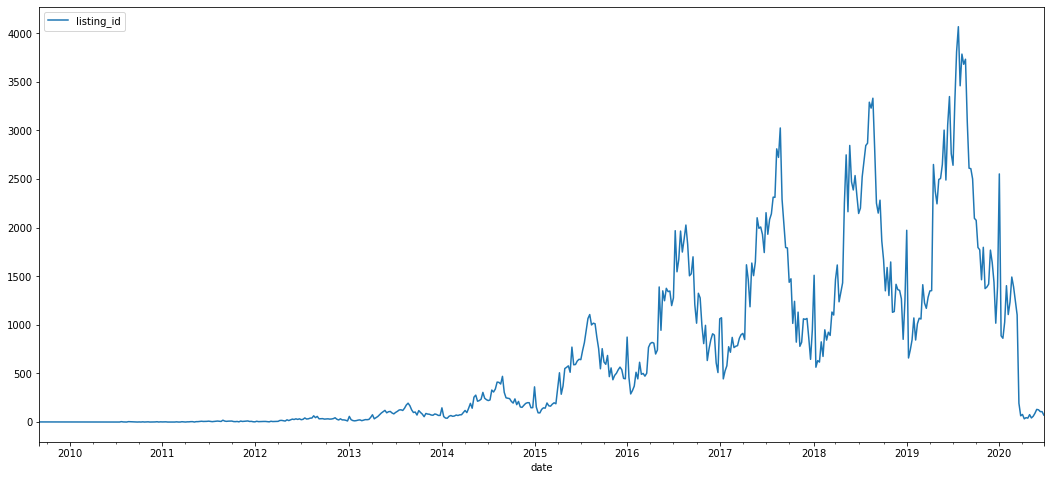

In [1700]:
df = df.resample('W').sum() 
df.plot(figsize=(18,8));

#### Checkpoint
<b> What's next ?</b>: We will analyse our data by week (lowering the resolution with respect to daily basis) in excahnge for computational time and  longer forecasting. There are few benefits and consequences. The obvious factors are:

- By lowering our resolution, we will reduce the number of observational points. Therefore, it's imperative to be careful with subsequent data treatments, in order to limit the loss of information.

- By summing up weekly reviews, we won't be dealing with the weekly seasonality.

### Step 3: Split the data into train and test

In [1746]:
train = df['2015-06':'2018']
test = df['2019']
print(train.shape)
print(test.shape)

(187, 1)
(52, 1)


<b> Observation </b>: Here, I decided to start the training set in mid-2015 to 2018. The reason for this is that earlier data has 0 to low values, which will likely influence the confidence interval of the forecast. Note that ARIMA models forecast values based on past data.

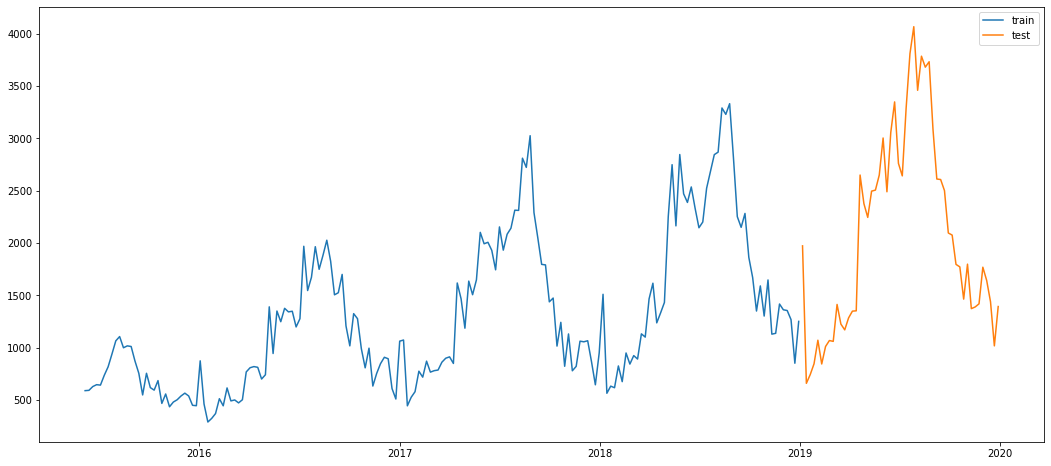

In [1710]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(train,label='train')
ax.plot(test,label='test')
ax.legend(loc='best');

<b>Observation</b>: We have successfully split the data at approximately 25%, which is a good splitting ratio between train and test.

<b> What's next?</b>: We need to benchmark the future forecast of our models from more simple analysis. We can use mean squared errors (MSE) or mean absolute percentage errors (MAPE).

### Step 4: Benchmark Forecasting Accuracy

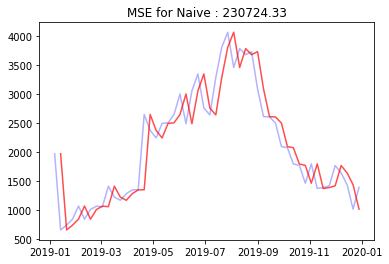

In [1659]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(test,test.shift().fillna(value=0)) #shifting value for one period.
plt.plot(test,color='blue',alpha=0.3)
plt.plot(test.shift(),color='red',alpha=0.7)
plt.title('MSE for Naive : {:.2f}'.format(MSE));

<b> Observation </b>: When we shift our data one period (i.e., one week) to the future; and consequently, get its corresponding MSE with the test data, we get a value of 230724.33. This MSE is our benchmark to know if our model is able to forecast into the future.

### Step 5: Test stationarity of data

Briefly, ARIMA model is statistical analysis of fitting past observations in order to predict future values. ARIMA stands for autoregressive (AR), integrative(I), moving average (MA). The model fits a number of AR and MA to a time series. It is imperative that the data must be <b> stationary </b>. 

<b>What's next?</b>: We will define a function called <mark>test_stationarity</mark> that tests for the stationarity of the data.

In [938]:
def test_stationarity(df,ts,wndw):
    
    """
    this function test of a time series stationarity
    """
    #Importing necessary packages
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import kpss
    np.set_printoptions(precision=2)
    
    #determining rolling statistics
    rolmean = df[ts].rolling(window=wndw,center=True).mean()
    rolstd = df[ts].rolling(window=wndw,center=True).std()
    
    #plotting the rolling statistics
    orig = plt.plot(df[ts],label=ts,alpha=0.4)
    mean = plt.plot(rolmean,label='rolling mean',alpha=0.9)
    std = plt.plot(rolstd,label='rolling std',alpha=0.9)
    
    #plot parameters
    plt.legend(loc='best')
    plt.title('Results of rolling statistics, %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    #perform ADF test
    print('Results of ADF test:')
    dftest = adfuller(df[ts],autolag='AIC',regression='c')
    dfoutput = pd.Series(dftest[:2],index=['Test Statistics',
                                           'p-value',])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

<b> A time series is said to be stationary if</b>:

- the mean and variance (could be standard deviation) has relatively dampened trend, with respect to the original data.

- we are able to reject the null hypothesis of augmented dickey-fuller (ADF) test. We can reject this if our p-value is lesser than the desired critical value, typically 0.05. 

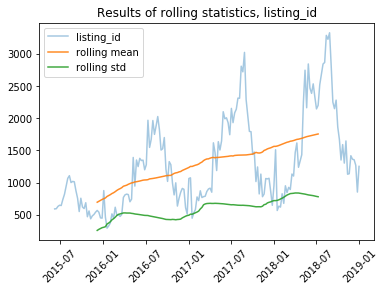

Results of ADF test:
Test Statistics        -2.202546
p-value                 0.205323
Critical Value (1%)    -3.466201
Critical Value (5%)    -2.877293
Critical Value (10%)   -2.575168
dtype: float64


In [939]:
test_stationarity(df=train,ts='listing_id',wndw=52)

<b>Observation</b>: With increasing rolling statistics over time and p-value > 0.05, it is obvious that our current data is <b>NOT</b> stationary.

<b> What's next? </b>: We need to transform the data in some way in order achieve stationarity. There are a few ways to transform the data but the simplest is differencing the data with a specific periodical shift. We will try to subtract our data with a single period shift.

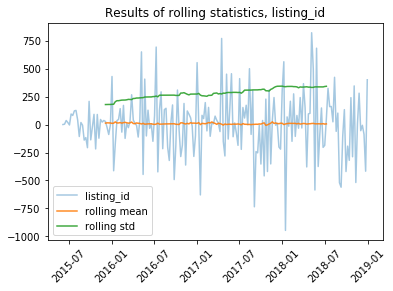

Results of ADF test:
Test Statistics        -1.743151e+01
p-value                 4.764181e-30
Critical Value (1%)    -3.466005e+00
Critical Value (5%)    -2.877208e+00
Critical Value (10%)   -2.575122e+00
dtype: float64


In [940]:
test_stationarity(df=train.diff().fillna(value=0),ts='listing_id',wndw=52)

<b>Observation</b>:  Visually, we see that the rolling statistics have more stable values in comparison to the raw data. Additionally, ADF test shows that the p-value is way below our critical value. This may imply that our data is stationary.

<b> What's next? </b>: We are ready to perform a simple ARIMA modelling.

### Step 6: Perform ARIMA modelling and forecasting

Generally, ARIMA models have 3 hyperparameters: p, d, and q. <b>p</b> and <b>q</b> correspond to the number of autoregressive and moving average coefficients, while <b>d</b> is the number of times the data should be differenced by one period to achieve stationarity.
    
We can impose a d >= 1, since we know from our stationary test that differencing the data by one period, yielded stationarity.

For p and q, we need to look at the autocorrelation and partial autocorrelation of the data.

The function bellow, called <mark>find_acf_pacf</mark> calculates the autocorrelation and partial autocorrlation of the data to a number of lags.

In [1577]:
def find_acf_pacf(df, ts, nlags):
    """
    get ACF and PACF values
    """
    #importing module
    from statsmodels.tsa.stattools import acf, pacf

    # determine ACF and PACF
    lag_acf = acf(np.array(df[ts]), nlags = nlags)
    lag_pacf = pacf(np.array(df[ts]), nlags = nlags)
    
    """
    Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
    """
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5))
    
    #Plot ACF: 

    ax1.bar(x = range(len(lag_acf)), height = lag_acf)
    ax1.axhline(y=0,linestyle='--',color='gray')
    ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax1.set_title('Autocorrelation Function for %s' %(ts))
    
    #Plot PACF:
    
    ax2.bar(x = range(len(lag_pacf)), height = lag_pacf)
    ax2.axhline(y=0,linestyle='--',color='gray')
    ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return

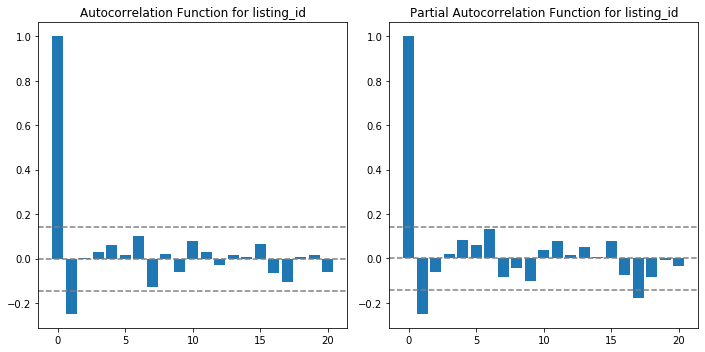

In [1578]:
find_acf_pacf(df=train.diff().fillna(value=0),ts='listing_id',nlags=20)

<b>Observation</b>:  Visually, we see that there is significant autocorrelation and partial autocorrelation for lag=1 and lag=7, since they are along or near the boundary of 95% confidence intervals of ACF and PACF values.

<b> What's next?</b>: Now we know a little bit of information about the likely p and q values, we can define a function called <mark>mse_arima</mark> that chooses the best p and q values, with respect to the MSE of test data and forecasted data. We will limit the parameterization to 7, as suggested by ACF/PACF plots above.

In [1246]:
def mse_arima(df,ts,max_param):
    
    """
    This function performs grid_search of arima parameters, determined by MSE of test and forecasted data
    """
    
    #removing warnings when running
    import warnings
    warnings.filterwarnings("ignore")
    
    #initializing p,d,q parameters
    import itertools
    max_param = max_param + 1
    p = q = range(0,max_param) 
    d = range(1,3) #imposing a rule that d can be between 1 and 2.
    order_params = list(itertools.product(p,d,q))
    
    #importing necessary modules
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_squared_error
    
    #initializing score and parameters
    best_score, best_params = float('inf'), None
    
    #performing grid-search
    for params in order_params:
        arima_model = SARIMAX(df[ts],order=params,seasonal_order=(0,0,0,0),
                              enforce_stationarity=False, enforce_invertibility=False,)
        arima_result = arima_model.fit()
        arima_forecast = arima_result.forecast(len(test.index))
        
        #calculating MSE
        try:
            MSE = mean_squared_error(arima_forecast,test)
            if MSE < best_score:
                best_score, best_params = MSE, params
                print('Best score so far - ARIMA{} - MSE:{:.3f}'.format(params,MSE))
        except:
            print('Cannot calculate MSE for ARIMA{:.3f}'.format(params))

In [1247]:
mse_arima(df=train,ts='listing_id',max_param=7)

Best score so far - ARIMA(0, 1, 0) - MSE:1557529.269
Best score so far - ARIMA(0, 2, 1) - MSE:1384157.653


<b>Observation</b>: By performing grid-search, ARIMA model with (p=0,d=2,q=1) showed best MSE. Basically, ARIMA(0,2,1) is an MA-model, because the autoregressive component remained 0. 

<b>What's next?</b>: We will analyse the result of ARIMA(0,2,1). We can use the SARIMAX module and impose a 0 value on seasonal_order and exogenous values.

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_result_1 = SARIMAX(train.listing_id,order=(0,2,1),seasonal_order=(0,0,0,0),
                       enforce_stationarity=False, enforce_invertibility=False,).fit(disp=-1)

NameError: name 'train' is not defined

<b>What's next?</b>: We can define a function that plots the train data and the model called <mark>plot_model</mark>

In [1711]:
def plot_model(arima):
    
    """
    Plotting the model
    """
    
    fig, ax = plt.subplots(figsize=(18,8))
    plt.plot(arima.fittedvalues,label='model')
    plt.plot(train,label='data')
    plt.legend(loc='best',fontsize='large')
    plt.title('Model vs Train, MSE:{:.3f}'.format(mean_squared_error(arima.fittedvalues,train)));

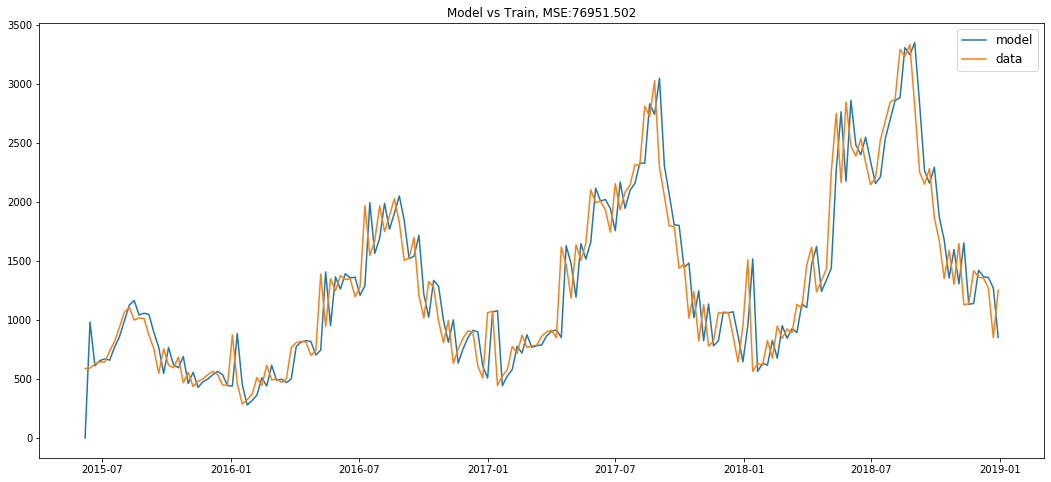

In [1712]:
plot_model(arima=arima_result_1)

<b> Observations</b>: As with all MA(n)-models, this MA(1)-model is the same as the data, just shifted one period ahead.

<b> What's next?</b>: We will evaluate the model by forecasting future data and comparing the forecast with test data using a function <mark>plot_forecast</mark>.

In [1713]:
def plot_forecast(arima,exog=None):
    
    """
    Plotting the forecasted values from model
    """
    predictions = arima.predict(start=test.index[0],end=test.index[-1],exog=exog)
    ci_values = arima.get_prediction(start=test.index[0],end=test.index[-1],exog=exog).conf_int()
    
    fig, ax = plt.subplots(figsize=(18,8))
    plt.plot(predictions,label='prediction')
    plt.plot(test,label='data')
    plt.fill_between(ci_values.index,ci_values.iloc[:,0],ci_values.iloc[:,1],color='k',alpha=0.15)
    plt.legend(loc='best',fontsize='large')
    plt.title('Forecast vs Test - MSE:{:.3f}'.format(mean_squared_error(test,predictions)));

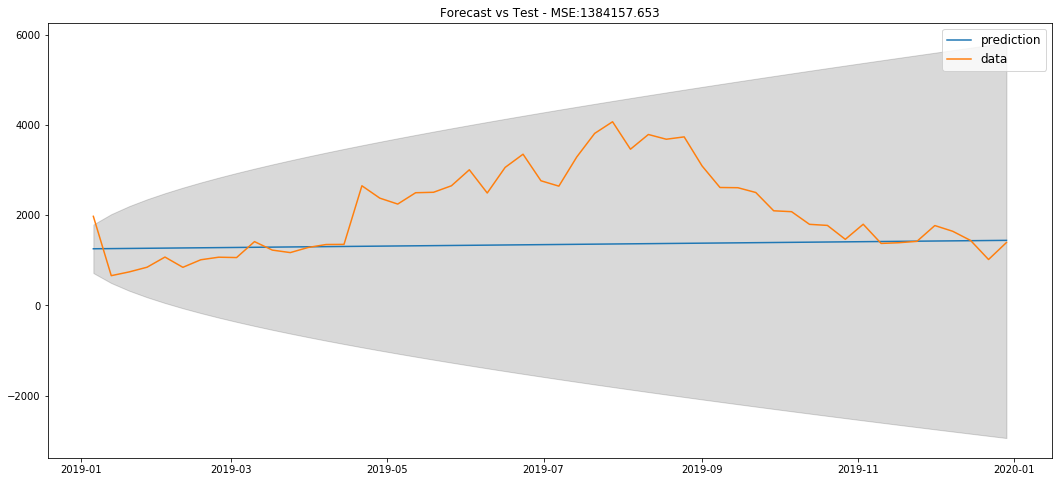

In [1714]:
plot_forecast(arima=arima_result_1)

<b> Observation </b>: Our model poorly performed in terms of forecasting data. This is expected since the model does not know any more information apart from the train data. Therefore, it cannot provide sensible future forecasts due to the lack of previous term.

<b>What's next?</b>: We can look at the residuals from ARIMA fitting. Here, I will run two analyses:

1) plot_diagnostics, which is a built-in function of ARIMA module

2) defined function called <mark>resid_analysis</mark>, which runs ACF and PACF of the residuals.

In [1581]:
def resid_analysis(df):
    """
    This makes a residual dataframe and runs it with find_acf_pacf function 
    """
    resid = pd.DataFrame(df.resid,index=train.index,columns=['resid'])
    return find_acf_pacf(df=resid,ts='resid',nlags=20)

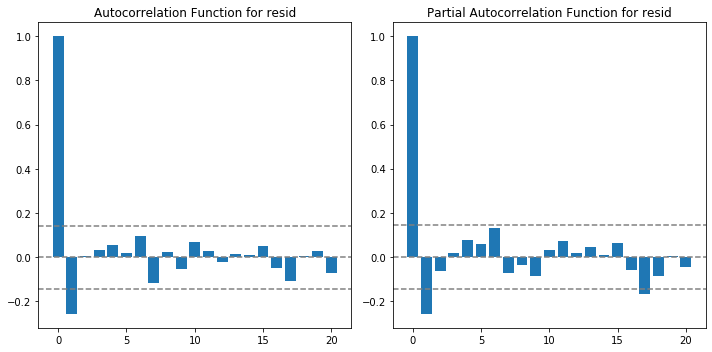

In [1582]:
resid_analysis(arima_result_1)

<b> Observations </b> ACF and PACF of our residuals show no correlation except for nlags=1. This means that we fit the model and data very well. This is also expected since we see a very good fit between the MA(1)-model and data.

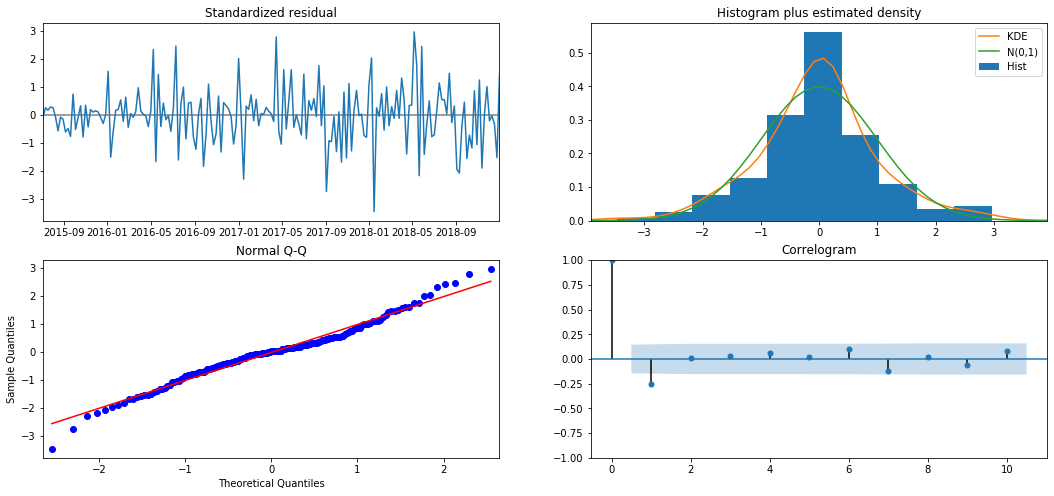

In [1684]:
arima_result_1.plot_diagnostics(figsize=(18,8)).show();

<b>Observation</b>: The plots above explain the residuals from the fit. Goodness of fit is achieved when:
- residuals oscillate at 0

- standardized histogram shows normal distribution

- linear (1:1) Q-Q plot

- correlogram shows poor correlation at nlags > 1

All of which seems to show good, which agrees well with our model and train data. One thing that we notice though, is that the residual plot shows very high variances at higher time points.

<b> What's next </b>: While our ARIMA model considerably fitted well with our training set, it failed to forecast the test data. <i>The cause of this could be due to negligence of the seasonal factor, which were not included in ARIMA model.</i> Moving forward, we need to perform seasonal ARIMA model (SARIMA).

### Step 7: Perform SARIMA modelling and forecasting

In this model, seasonal parameters should be added, (P,D,Q,s), or in my code (sp,sd,sd,ss). We will perform a grid search for sp, sd, and sq, while we fix <b> ss = 4 </b>, since the frequency of our data is weekly. An ideal ss value should be 52, because we have observed that seasonality ocurrs yearly. However, if we do this, we will lose 52 data points, which is not a good strategy for our limited data point. The <mark> mse_sarima </mark> function performs a grid search of 6 SARIMA variables, and spits out best MSE values. Note that <b>this function takes time</b>.

In [1583]:
def mse_sarima(df,ts,max_param,exog=None):
    """
    grid search of SARIMA
    """
    #initializing parameters
    import itertools
    p = q = range(0,max_param)
    d = range(0,3) #imposing difference to be 0 to 2
    sp = sq = range(0,max_param+1) #sp and sq should be greater than p and q.
    sd = range(0,3) #imposing seasonal difference to be 0,2
    order_params = list(itertools.product(p,d,q))
    season_params = list(itertools.product(sp,sd,sq,[4])) #impose ss=4
    
    #import necessary modules
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_squared_error
    
    #initializing score
    
    best_score= float('inf')
    
    for order_config in order_params:
        for season_config in season_params:
            arima_model = SARIMAX(df[ts],order=order_config,seasonal_order=season_config,exog=exog,
                              enforce_stationarity=False, enforce_invertibility=False,)
            arima_result = arima_model.fit()
            arima_forecast = arima_result.forecast(len(test))
            
            MSE = mean_squared_error(test,arima_forecast)
            
            try:
                if MSE < best_score:
                    best_score, best_order, best_season = MSE, order_config, season_config
                    print('Best score so far - ARIMA{},SARIMA{} - MSE:{:.3f}'.format(order_config,
                                                                                 season_config,best_score))
            except:
                print('Cannot calculate MSE for ARIMA{},SARIMA{}'.format(order_config,season_config))

In [1306]:
mse_sarima(df=train,ts='listing_id',max_param=4)

Best score so far - ARIMA(0, 0, 0),SARIMA(0, 0, 0, 4) - MSE:5206792.500
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 0, 1, 4) - MSE:5140882.217
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 0, 2, 4) - MSE:5090343.555
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 0, 3, 4) - MSE:5037788.567
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 0, 4, 4) - MSE:4986201.827
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 1, 0, 4) - MSE:1670303.327
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 1, 2, 4) - MSE:1660072.308
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 1, 4, 4) - MSE:1029136.141
Best score so far - ARIMA(0, 0, 0),SARIMA(1, 0, 4, 4) - MSE:746440.635
Best score so far - ARIMA(0, 0, 0),SARIMA(2, 0, 4, 4) - MSE:735186.297
Best score so far - ARIMA(0, 0, 0),SARIMA(2, 1, 2, 4) - MSE:240990.059
Best score so far - ARIMA(0, 0, 0),SARIMA(2, 1, 4, 4) - MSE:215400.373
Best score so far - ARIMA(0, 0, 0),SARIMA(4, 0, 4, 4) - MSE:189790.327
Best score so far - ARIMA(0, 0, 0),SARIMA(4, 1, 2, 4) - MSE:187562.01

<b>Observation</b>: By performing grid-search, we see that our SARIMA model with (p,d,q)x(sp,sd,sq,ss) = (0,0,1)x(3,1,3,4) showed best MSE.

<b>What's next?</b>: We will analyse the result of this SARIMA(0,0,1)x(3,1,3,4) model.

In [1307]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_result_1 = SARIMAX(train.listing_id,order=(0,0,1),seasonal_order=(3,1,3,4),
                      enforce_stationarity=False, enforce_invertibility=False,).fit(disp=-1)

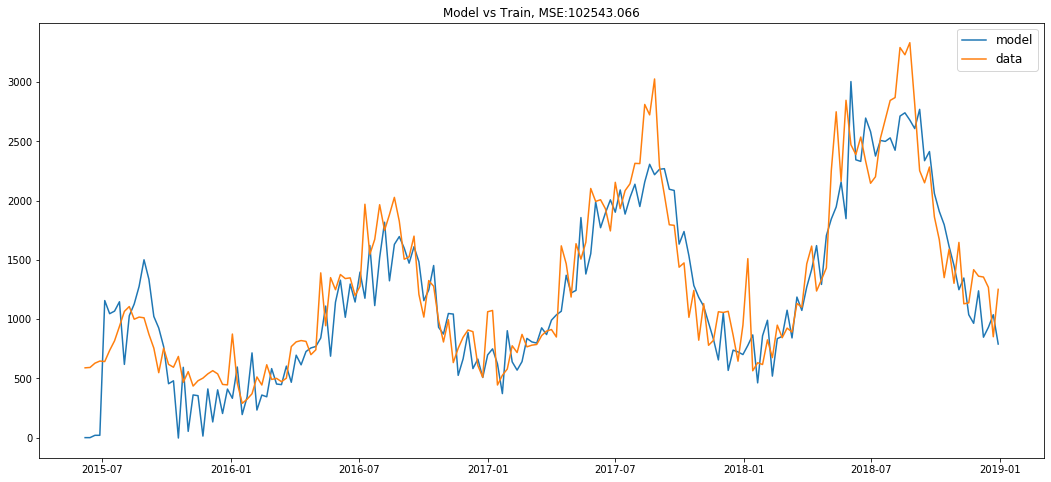

In [1715]:
plot_model(sarima_result_1)

<b> Observation </b>: Our SARIMA model shows good fit with the train data. Note that our SARIMA model has lower MSE, relative to the ARIMA - MA(1) model. This is expected because in this model, we are fitting numerous coefficients that could explain the train data. 

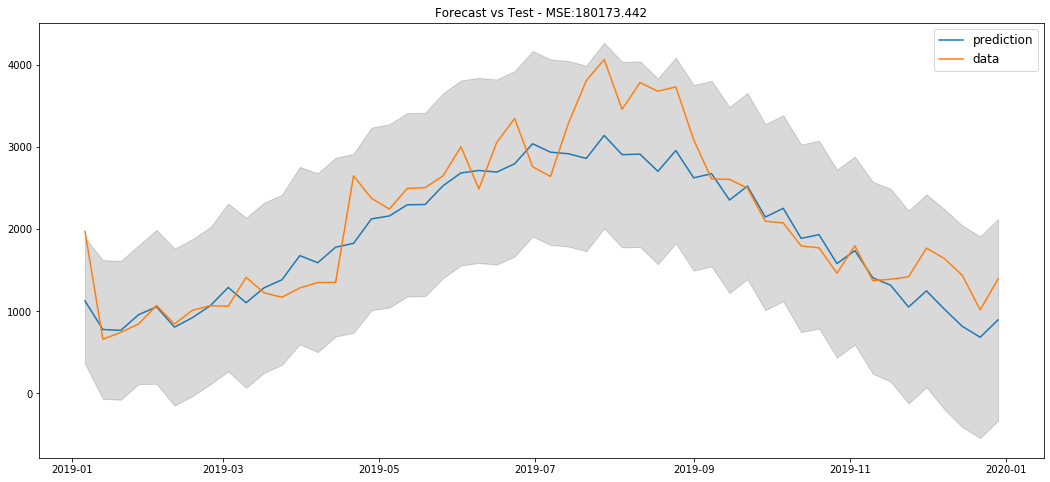

In [1716]:
plot_forecast(sarima_result_1)

<b>Observation</b>: Our forecast can now identify the yearly cyclic characteristic of our test data. This forecast also faired better than ARIMA and our baseline forecast.

Overall, the forecasting capability of SARIMA is superior than ARIMA, especially with data that has obvious seasonality.

<b>What's next?</b>: We could analyse the residual of SARIMA fitting.

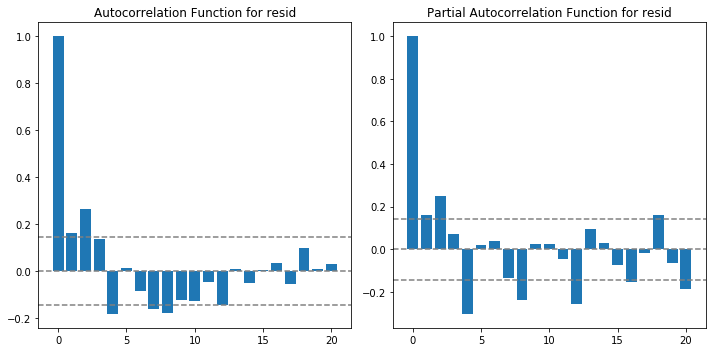

In [1310]:
resid_analysis(sarima_result_1)

<b>Observation</b>: ACF shows correlation at nlags=1,2 and PACF at nlags=1,2,4. This may be dampened by fine-tuning our SARIMA model further. This may likely result to a better fit with train, but <b> NOT</b> necessarily better forecasting.

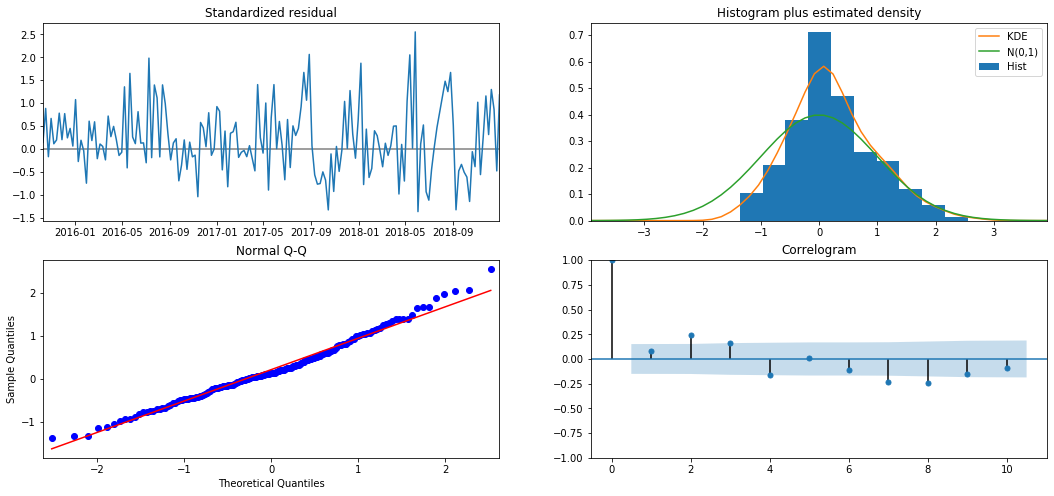

In [1683]:
sarima_result_1.plot_diagnostics(figsize=(18,8)).show();

<b>Observation</b>: Looking at residual properties. We can say that the standardized residual has higher oscillations at positive values, making the histogram distribution and Q-Q plots skewed. This may be due to some peaks that cannot be captured by our SARIMA model.

<b>What's next?</b>: I would focus more with the information given by plot_diagnostics because we can easily visualize in which part of our model is failing by looking at the residual. Moving forward, let's try to dig deeper into the training data and residual to see if there are specific dates that we can flag as spikes or 'peak weeks'.

### Step 8: Analyse residual

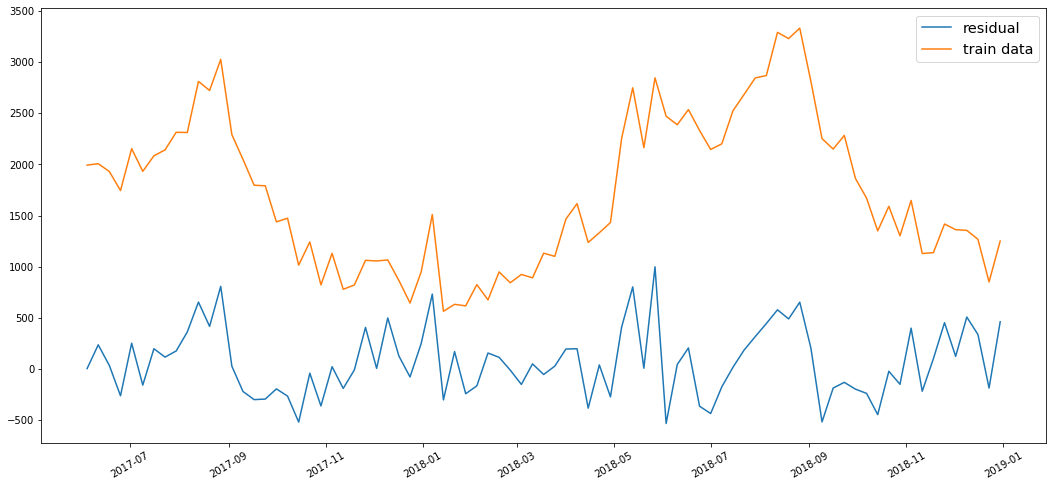

In [1719]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(sarima_result_1.resid['2017-06':'2018'],label='residual')
plt.plot(train['2017-06':'2018'],label='train data')
plt.xticks(rotation=30)
plt.legend(loc='best',fontsize='x-large');

<b>Observation</b>: When plotting both the train and residual data, we can see matching peaks in the weeks 1(january), 20(may), and 35(august). These matching peaks are the 'peak weeks' that our model was unable to capture, hence revealing in the residual data.

<b>What's next?</b>: Since our data is in a weekly basis, and we are unable to identify the specific day that drive these spikes. What we can do is to manually identify these peaks.

After manual inspection, we have flagged weeks 1, 21, and 34 as main drivers of our peaks. Obviously, this makes sense because: week 1 - New Year's Eve, week 21 - Spring Break, week 34 - Summer Break, which drives up the number of Airbnb usage in Copenhagen.

### Step 7: Label 'peak weeks'.

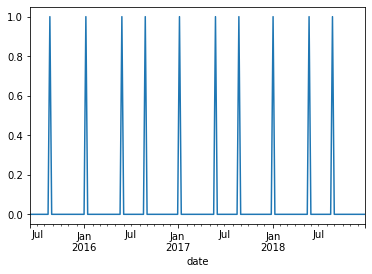

In [1556]:
week_of_year = pd.DataFrame(train.index.weekofyear,index=train.index)
#holiday_months = [1,21,34]
week_of_year['peak_week'] = week_of_year.date.apply(lambda x: 1 if x ==1 or x==21 or x==34 else 0)
exog_variable = week_of_year.peak_week
exog_variable.plot();

<b> Observation</b>: We have successfully created an exog_variable data in our training set that tags week 1, 21, and 34 with value = 1.

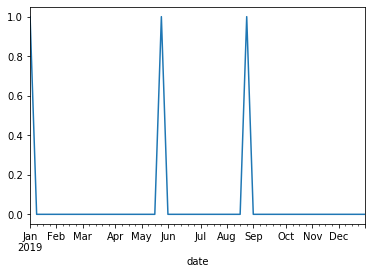

In [1585]:
week_of_year_test = pd.DataFrame(test.index.weekofyear,index=test.index)
week_of_year_test['peak_week'] = week_of_year_test.date.apply(lambda x: 1 if x ==1 or x==21 or x==34 else 0)
exog_variable_test = week_of_year_test.peak_week
exog_variable_test.plot();

<b> Observation</b>: Similarly, we have successfully created an exog_variable data in our test set that tags week 1, 21, and 34 with value = 1.

<b> What's next?</b>: We will use the peak_week features as exogenous variable and perform SARIMAX. Simply, the 'X' in SARIMA(X) stands for the exogenous in ARIMA modelling

### Step 8: Perform SARIMAX modelling and forecasting

In defining the <mark>mse_sarimax</mark> function, it is good to note that exogenous variables should be added as an argument in both modelling (exog_variable) and forecasting(exog_variable_test).

In [ ]:
def mse_sarimax(df,ts,max_param,exog=None):
    """
    grid search of SARIMAX
    """
    #initializing parameters
    import itertools
    p = q = range(0,max_param)
    d = range(0,3) #imposing difference to be 0 to 2
    sp = sq = range(0,max_param+1) #sp and sq should be greater than p and q.
    sd = range(0,3) #imposing seasonal difference to be 0,2
    order_params = list(itertools.product(p,d,q))
    season_params = list(itertools.product(sp,sd,sq,[4])) #impose ss=4
    
    #import necessary modules
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_squared_error
    
    #initializing score
    
    best_score= float('inf')
    
    #modelling step
    for order_config in order_params:
        for season_config in season_params:
            arima_model = SARIMAX(df[ts],order=order_config,seasonal_order=season_config,exog=exog, #add exog argument
                              enforce_stationarity=False, enforce_invertibility=False,)
            arima_result = arima_model.fit()
            
            #forecasting step
            arima_forecast = arima_result.forecast(len(test),exog=exog_variable_test) #manually add exog argument
            
            
            #evaluating step
            MSE = mean_squared_error(test,arima_forecast)
            
            try:
                if MSE < best_score:
                    best_score, best_order, best_season = MSE, order_config, season_config
                    print('Best score so far - ARIMA{},SARIMA{} - MSE:{:.3f}'.format(order_config,
                                                                                 season_config,best_score))
            except:
                print('Cannot calculate MSE for ARIMA{},SARIMA{}'.format(order_config,season_config))

In [1592]:
mse_sarimax(df=train,ts='listing_id',max_param=4,exog=exog_variable)

Best score so far - ARIMA(0, 0, 0),SARIMA(0, 0, 0, 4) - MSE:4810321.698
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 0, 4, 4) - MSE:4709658.952
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 1, 0, 4) - MSE:1601948.629
Best score so far - ARIMA(0, 0, 0),SARIMA(0, 1, 4, 4) - MSE:993111.244
Best score so far - ARIMA(0, 0, 0),SARIMA(1, 0, 3, 4) - MSE:801292.589
Best score so far - ARIMA(0, 0, 0),SARIMA(1, 0, 4, 4) - MSE:781720.090
Best score so far - ARIMA(0, 0, 0),SARIMA(2, 1, 2, 4) - MSE:172486.152
Best score so far - ARIMA(0, 0, 0),SARIMA(4, 1, 2, 4) - MSE:169939.442
Best score so far - ARIMA(0, 0, 1),SARIMA(4, 1, 2, 4) - MSE:152941.933


<b>Observation</b>: With exogenous variable the best parameters is (0,0,1)x(4,1,2,4)

In [1593]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_result_1 = SARIMAX(train.listing_id,order=(0,0,1),seasonal_order=(4,1,2,4),exog=exog_variable,
                      enforce_stationarity=False, enforce_invertibility=False,).fit(disp=-1)

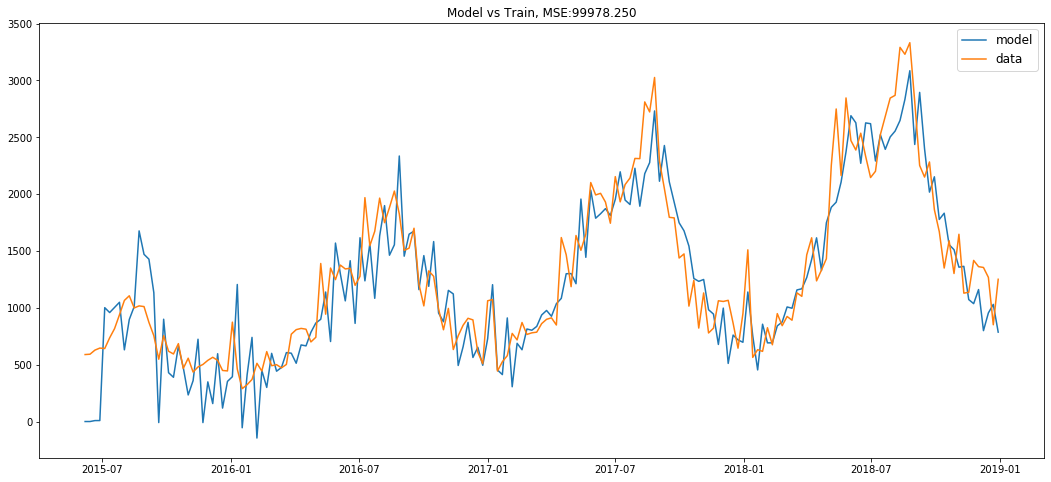

In [1720]:
plot_model(sarimax_result_1)

<b>Observations</b>: By adding the exogenous variables, the 'peak weeks' are now added in the model, as shown from the addition of information in the model.

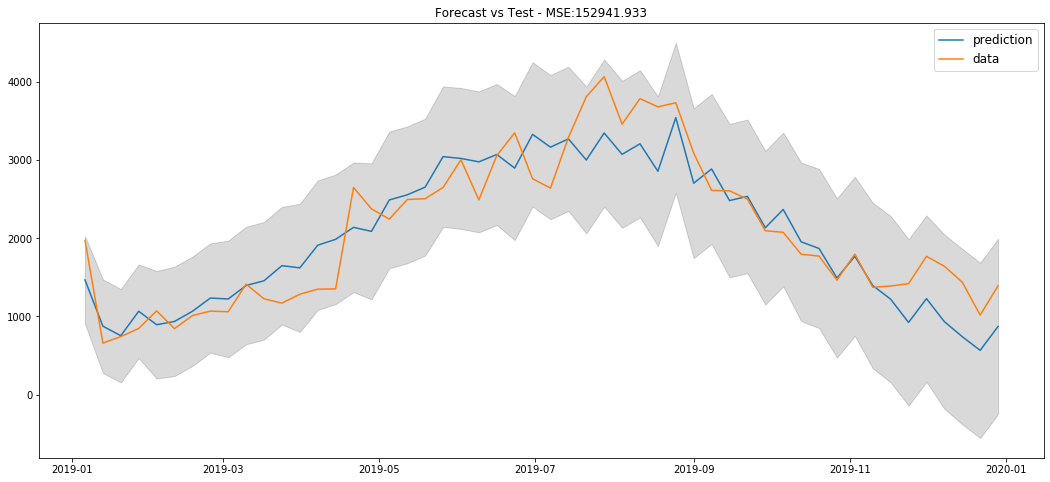

In [1721]:
plot_forecast(arima=sarimax_result_1,exog=exog_variable_test)

<b>Observation</b>: Comparison between SARIMAX forecast and test data, we see better MSE values in comparison to SARIMA. It is also good to note that the test data lies within the 95% confidence interval of our forecasted data, suggesting agreeable results.

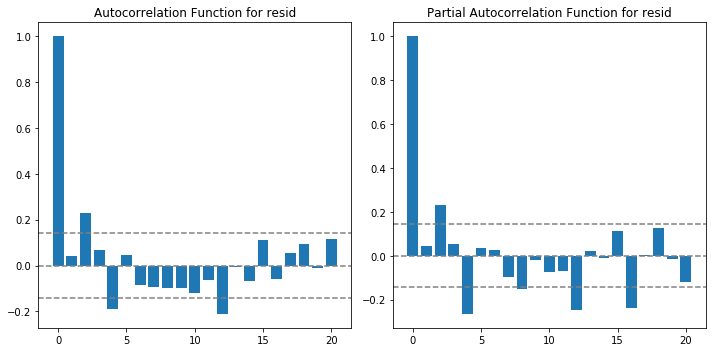

In [1596]:
resid_analysis(sarimax_result_1)

<b>Observation</b>: Residual analysis still show autocorrelation at nlags=2,4. This could be due to serveral reasons. The most obvious is that we fixed our ss = 4. Therefore we are limited with how much p, q, sp, and sq we should add to the model.

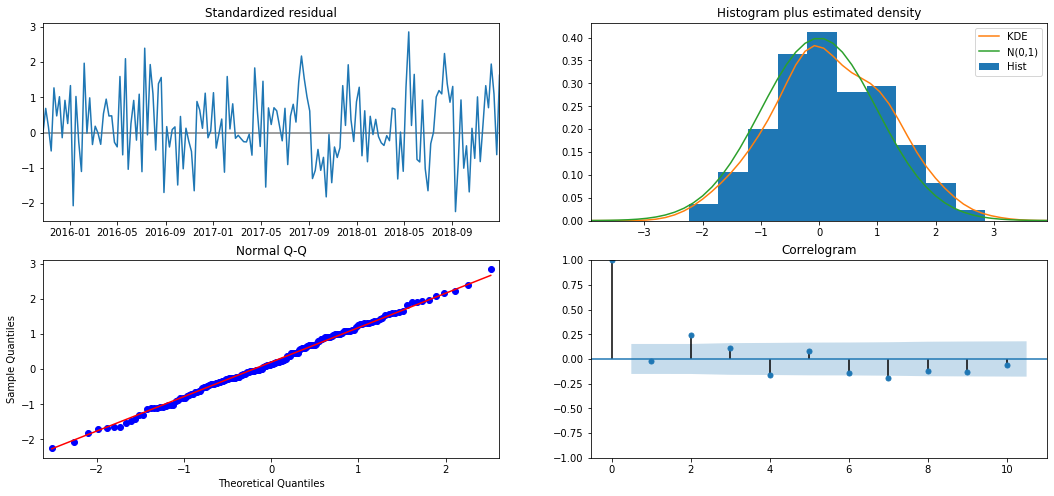

In [1682]:
sarimax_result_1.plot_diagnostics(figsize=(18,8)).show();

<b>Observation</b>: Diagnosis of residuals show that oscillations are biased slightly at positive values but faired very well in comparison to ARIMA and SARIMA models. This is also obvious in the almost normally distributed histogram plot and a very linear Q-Q plot.

<b>What's next?</b>: Typically, my SARIMAX modelling and forecasting ends here. I will now plot the final model and forecasting results.

<i>Note that I attempted to perform SARIMAX model to log transformed data but the MSE for forecast vs. test did not improve</i>.

### Step 9: Plotting data

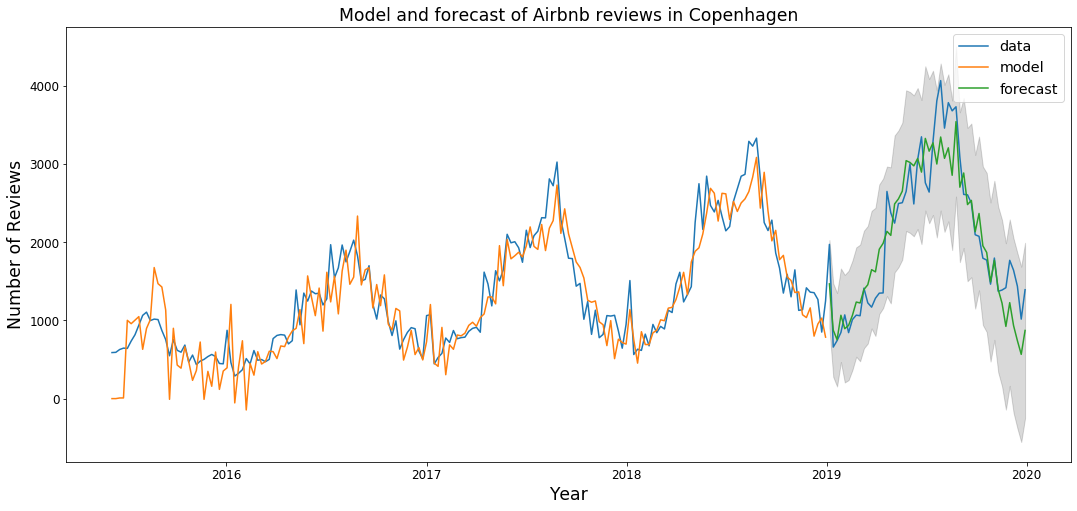

In [1681]:
fig, ax = plt.subplots(figsize=(18,8))

#get the confidence interval
ci_values = sarimax_result_1.get_prediction(start=test.index[0],end=test.index[-1],exog=exog_variable_test).conf_int()
lower_ci = ci_values.iloc[:,0]
upper_ci = ci_values.iloc[:,1]


#plot the data
ax.plot(pd.concat([train,test]),label='data')
ax.plot(sarimax_result_1.predict(start=train.index[0],end=train.index[-1],
                                 exog=exog_variable),label='model')
ax.plot(sarimax_result_1.forecast(steps=len(exog_variable_test.index),
                                  exog=exog_variable_test),label='forecast')
ax.fill_between(ci_values.index,upper_ci,lower_ci, color='k', alpha=.15)
ax.legend(loc='best',fontsize='x-large')

#add detials
ax.set_title('Model and forecast of Airbnb reviews in Copenhagen',fontsize='xx-large')
ax.set_ylabel('Number of Reviews',fontsize='xx-large')
ax.set_xlabel('Year',fontsize='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large');


#### Conclusion:

We have modelled and forecasted Airbnb reviews in Copenhagen using SARIMAX. Specifically, we started with a simpler model (ARIMA/MA(1)) and scaled its complexity, by including seasonal (SARIMA) and exogenous features (SARIMAX). Overall, SARIMAX faired really well in comparison to other models and to the benchmark forecast. Not only, we incorporated the yearly seasonality of the data, but also of the 'peak review' weeks, which were attributed to new year, spring and summer breaks.